In [1]:
import pandas as pd
from utils.constants import Paths

In [2]:
user_df = pd.read_parquet(Paths.RAW_DATA_PARQUET / "user/pothole_311.parquet")

In [3]:
user_columns = [
    "Location",
    "Status",
    "Resolution Description",
    "Created Date",
    "Resolution Action Updated Date",
    "Street Name",
    "Cross Street 1",
    "Cross Street 2",
    "Intersection Street 1",
    "Intersection Street 2",
    "Address Type",
    "Incident Zip",
]

In [4]:
user_df = user_df[user_columns]

## Step 2: Processing Dataframe metadata

In [5]:
user_rename_map = {
    "Location": "geometry",
    "Status": "status",
    "Resolution Description": "resolution_description",
    "Created Date": "date_created",
    "Resolution Action Updated Date" : "date_closed",
    "Street Name": "street_name",
    "Cross Street 1": "cross_street_1",
    "Cross Street 2": "cross_street_2",
    "Intersection Street 1": "intersection_street_1",
    "Intersection Street 2": "intersection_street_2",
    "Address Type": "address_type",
    "Incident Zip": "zip_code",
}

user_df = user_df.rename(columns=user_rename_map)

In [6]:
user_df = user_df[~user_df['address_type'].isna()].dropna(subset=['geometry'])

In [7]:
user_df = user_df[user_df['status'] == "Closed"]
open_complaints_df = user_df[user_df['status'] != "Closed"]

user_df = user_df.drop(columns=["status"])

## Step 3: Cleaning Data

In [8]:
user_df['address_type'] = user_df['address_type'].replace('BLOCKFACE', 'ADDRESS')
user_df = user_df[user_df['address_type'] != 'PLACENAME']

Here we separate open and closed DataFrames, this is because the processing and grouping deals with response times

In [9]:
valid_complaint_strings = {
    "The Department of Transportation inspected this complaint and repaired the problem.",
    "The Department of Transportation has completed the request or corrected the condition.",
    "The Department of Transportation inspected the condition and temporary repairs were made to make the area safe. Permanent repairs/restoration will be scheduled as part of a project, seasonal work (April - November), or when work is assigned to a contractor.",
    "The Department of Transportation inspected this complaint and barricaded the area. The issue was referred to another unit for further action.",
}

In [10]:
user_df = user_df[user_df['resolution_description'].isin(valid_complaint_strings)]
user_df = user_df.drop(columns=['resolution_description'])

In [11]:
import numpy as np

In [12]:
user_df = user_df[~((user_df['address_type'] == 'ADDRESS') & (user_df['cross_street_1'].isnull() | user_df['cross_street_2'].isnull()))]

In [13]:
user_df = user_df[~((user_df['address_type'] == 'INTERSECTION') & (user_df['intersection_street_1'].isnull() | user_df['intersection_street_2'].isnull()))]

In [14]:
address_mask_user = user_df['address_type'] == 'ADDRESS'
user_df.loc[address_mask_user, 'street'] = user_df.loc[address_mask_user, 'street_name'] + ', ' + user_df.loc[address_mask_user, ['cross_street_1', 'cross_street_2']].apply(sorted, axis=1).str.join(', ')

In [15]:
intersection_mask_user = user_df['address_type'] == 'INTERSECTION'
user_df.loc[intersection_mask_user, 'street'] = user_df.loc[intersection_mask_user, ['intersection_street_1', 'intersection_street_2']].apply(sorted, axis=1).str.join(', ')

In [16]:
user_df['date_created'] = pd.to_datetime(user_df['date_created'])
user_df['date_closed'] = pd.to_datetime(user_df['date_closed'])

In [17]:
user_df["response_time"] = (user_df["date_closed"] - user_df["date_created"]).dt.days
user_df = user_df[user_df["response_time"] >= 0]

## Step 4: Counting duplicate complaints

In [18]:
user_df = user_df.sort_values(['date_created','street'])
user_df['num_requests'] = 0


In [19]:
res_df = pd.DataFrame()

In [20]:
from pandas import Timedelta

In [21]:
res_df = pd.DataFrame()
cnt = 0
for zip_code in user_df['zip_code'].unique():
    cnt += 1
    print(f"{cnt}/{len(user_df['zip_code'].unique())}")
    group = user_df[user_df['zip_code'] == zip_code]
    group = group.reset_index(drop=True)

    for i in range(len(group) - 1):
        if group.at[i, 'num_requests'] < 0:
            continue

        count = 0
        
        for j in range(i + 1, len(group)):
            if (group.iloc[j]['street'] == group.iloc[i]['street'] and
                group.iloc[j]['date_created'] <= (group.iloc[i]['date_closed'] + Timedelta(1, unit='D'))):
                count += 1
                group.at[j, 'num_requests'] = -1
            else:
                break
        group.at[i, 'num_requests'] = count
    
    res_df = pd.concat([res_df, group])

1/235
2/235
3/235
4/235
5/235
6/235
7/235
8/235
9/235
10/235
11/235
12/235
13/235
14/235
15/235
16/235
17/235
18/235
19/235
20/235
21/235
22/235
23/235
24/235
25/235
26/235
27/235
28/235
29/235
30/235
31/235
32/235
33/235
34/235
35/235
36/235
37/235
38/235
39/235
40/235
41/235
42/235
43/235
44/235
45/235
46/235
47/235
48/235
49/235
50/235
51/235
52/235
53/235
54/235
55/235
56/235
57/235
58/235
59/235
60/235
61/235
62/235
63/235
64/235
65/235
66/235
67/235
68/235
69/235
70/235
71/235
72/235
73/235
74/235
75/235
76/235
77/235
78/235
79/235
80/235
81/235
82/235
83/235
84/235
85/235
86/235
87/235
88/235
89/235
90/235
91/235
92/235
93/235
94/235
95/235
96/235
97/235
98/235
99/235
100/235
101/235
102/235
103/235
104/235
105/235
106/235
107/235
108/235
109/235
110/235
111/235
112/235
113/235
114/235
115/235
116/235
117/235
118/235
119/235
120/235
121/235
122/235
123/235
124/235
125/235
126/235
127/235
128/235
129/235
130/235
131/235
132/235
133/235
134/235
135/235
136/235
137/235
138/235
139/

## Step 5: Adding geographic data

In [22]:
import geopandas as gpd
import ast
from shapely.geometry import Point

In [23]:
res_df['geometry'] = res_df['geometry'].apply(lambda loc: (lambda y, x: Point(x, y))(*ast.literal_eval(loc)))
open_complaints_df['geometry'] = open_complaints_df['geometry'].apply(lambda loc: (lambda y, x: Point(x, y))(*ast.literal_eval(loc)))

In [24]:
res_gdf = gpd.GeoDataFrame(res_df, geometry='geometry', crs='EPSG:4326')

## Step 6: Adding census data

In [48]:
census_df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "census_data.parquet")

In [49]:
from shapely import wkt

census_df['geometry'] = census_df['geometry'].apply(wkt.loads)

In [50]:
census_gdf = gpd.GeoDataFrame(census_df, geometry='geometry', crs='EPSG:4326')

In [51]:
# join results with census, the point in results_gdf needs to be within the_geom polygon in census_gdf, needs to be inner join
results_census_gdf = gpd.sjoin(res_gdf, census_gdf, how="inner", op='within')

/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [52]:
results_census_gdf = results_census_gdf.drop(columns=['geometry', 'index_right'])

In [57]:
cols = [
    "date_created",
    "date_closed",
    "borough",
    "neighborhood",
    "zip_code",
    "street",
    "response_time",
    "num_requests",
    "geo_id",
    "bct_num",
    "median_age",
    "hispanic_pct",
    "white_nh_pct",
    "black_nh_pct",
    "asian_nh_pct",
    "other_nh_pct",
    "two_plus_nh_pct",
    "average_hh_size",
    "less_than_hs_pct",
    "hs_pct",
    "some_college_pct",
    "associate_degree_pct",
    "bachelors_or_higher_pct",
    "median_household_income",
    "median_income_black",
    "median_income_native",
    "median_income_asian",
    "median_income_pacific_islander",
    "median_income_other",
    "median_income_two_plus",
    "median_income_white",
    "median_income_hispanic",
]

In [58]:
results_census_gdf = results_census_gdf[cols]

In [60]:
results_census_gdf.to_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_pothole.parquet")
results_census_gdf.to_csv(Paths.PROCESSED_DATA_CSV / "aggregated_pothole.csv", index=False)

## Step 7: Visualization

In [44]:
import matplotlib.colors as colors
from tabulate import tabulate

In [45]:
hexbin_plot_gdf = res_gdf.to_crs(epsg=3857)

In [46]:
vmin, vmax = np.percentile(hexbin_plot_gdf['response_time'], [5, 95])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

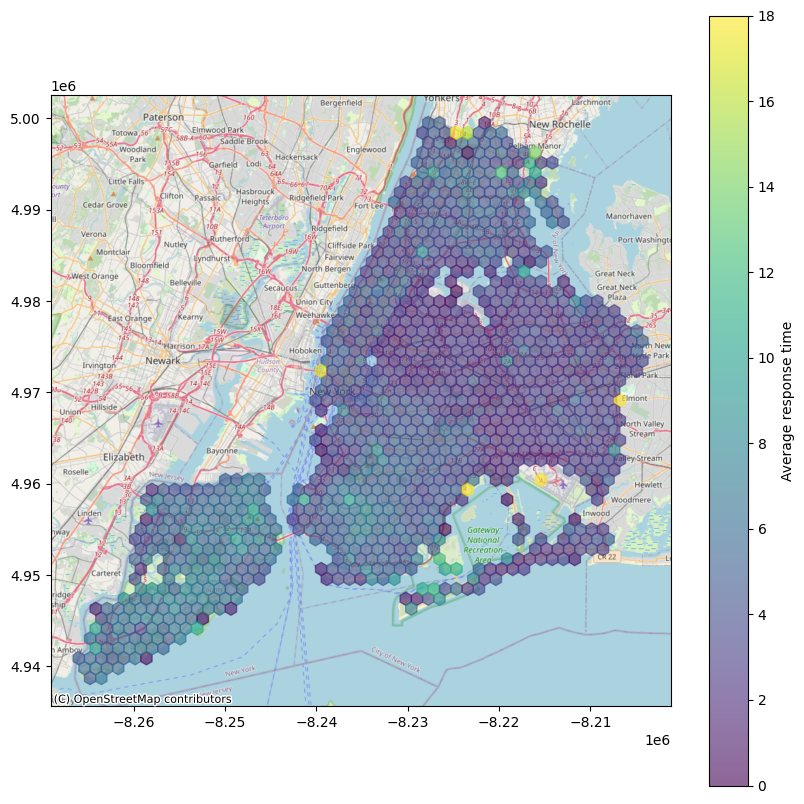

In [47]:
import contextily as ctx
import matplotlib.pyplot as plt

tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = hexbin_plot_gdf.geometry.x
y = hexbin_plot_gdf.geometry.y

hb = ax.hexbin(x, y, C=hexbin_plot_gdf['response_time'], gridsize=50, reduce_C_function=np.mean, cmap='viridis', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Average response time')

# Add the basemap
ctx.add_basemap(ax, crs=hexbin_plot_gdf.crs.to_string(), source=tile_provider)

plt.show()

In [61]:
print(tabulate(results_census_gdf.sort_values(by="num_requests",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+---------------------+---------------------+-----------+----------------------------------------------+------------+----------------------------------------------------+-----------------+----------------+-------------+-----------+--------------+----------------+----------------+----------------+----------------+----------------+-------------------+-------------------+--------------------+----------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+------------------------+-----------------------+----------------------------------+-----------------------+--------------------------+-----------------------+--------------------------+
| date_created        | date_closed         | borough   | neighborhood                                 |   zip_code | street                                             |   response_time |   num_requests |      geo_id |   bct_num |   median_age |   hispanic_pct |   white_nh_pct |   b

In [44]:
results_census_gdf.sort_values(by="num_requests",ascending=False).head(1)['street']

201929    ROOSEVELT AVENUE, MAIN STREET, PRINCE STREET
Name: street, dtype: object